In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [44]:
train = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[:80%]")
test = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[80%:]")
# Loading the datasets. Nb that you might have to remove the data_dir parameter if you are running the notebook somewhere else.

max_x = max_y = max_z = 0
min_x = min_y = min_z = 400

# We want to know how big the size differences in our dataset are, so we just check every image's dimension.
# This is exploratory, not really part of the model, so when running the model, should be disabled.
train2 = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[:80%]")
for i in train2:
    # print(i)
    for j in i:
        if j.dtype==tf.uint8:
            (x, y, z) = j.shape
            max_x = max(x,max_x)
            max_y = max(y,max_y)
            max_z = max(z,max_z)

            min_x = min(x,min_x)
            min_y = min(y,min_y)
            min_z = min(z,min_z)
print("max_x, max_y, max_z, min_x, min_y, min_z \n", max_x, max_y, max_z, min_x, min_y, min_z)

max_x, max_y, max_z, min_x, min_y, min_z 
 385 394 3 40 46 3


Alright, we need first a feature extractor then a classifier

What are the classes that we are looking for? It's infected (label 0) and non-infected (label 1). 
You can nicely see the infected cells by the staining in the images. 

We will use 4 four hidden layers with pooling layers inbetween them.

This means:
* Input
* Convolution layer
* Pool
* Convolution layer
* Pool 
* Repeat this until we have 4 concolution layers and 4 pools
* Global Pool
* Classifier (output layer)
* Output

One issue we are facing is that the dataset images are of very different sizes. This will require padding!
Which type of padding do we want to use? The differences in dimensions are staggering! The smallest image is far smaller than the biggest one.
It would be a good idea to print some of the images, especially large and small ones, to see how padding would affect them.

Options are:
* Crop to quadratic shape
* Resize and fill the empty space with zeroes
* resize and stretch the image

We picked Resize and fill the empty space with zeroes, since the cell size might be interesting data to have, and the images are zero-padded already to make them quadratic anyways.

<Figure size 576x576 with 0 Axes>

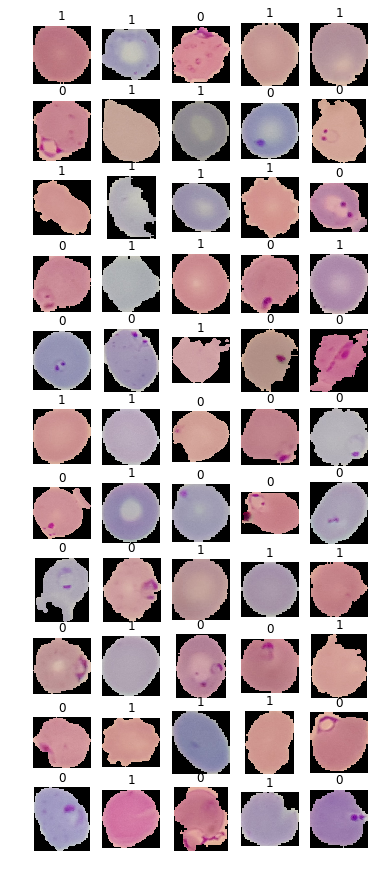

In [45]:
def tile_plot(train,imgs=55,greyscale=False,scale=False):
    # This function plots the images in a tiled fashion, for better visualization.
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 10
    fig, ax = plt.subplots(1,imgs)
    for i,j in enumerate(train):
        img= j[0]
        lbl = j[1].numpy()
        subax = fig.add_subplot(rows+1,columns+1,i+1)   
        subax.axis("off")
        subax.set_title(lbl)

        if greyscale: #Dealing with grayscale images requires a different approach, since imshow doesn't handle them as adroitly as RGB
            if scale: # This is to visualize our normalized images. Since this doesn't conform to the standard scale, we have to define our own
                plt.imshow(np.squeeze(img),vmin=-2, vmax= 2.5,cmap="gray")
            else:
                plt.imshow(tf.cast(np.squeeze(img),tf.uint8),cmap="gray")
        else:
            plt.imshow(tf.cast(img,tf.uint8)) #cast to uint because otherwise there's an error from matplotlib
        ax[i].axis("off")
        if i == (imgs-1): 
            # this is really awkward, but sadly prefetch_datasets are quite particular about indexing.
            # converting them to numpy first might be smarter in the future
            break
    plt.subplots_adjust(top=3)
    plt.show()

tile_plot(train)

In [46]:
#train = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[:80%]")
#test = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[80%:]")

# Ultimately, we do have to use a smaller iamge size, since the planned 400x400 was just too computstionally intensive. 
# We still reach high accuracy with this. How low could we go to achieve that?
target_height = 70
target_width = 70

train = train.map(lambda x,y : (tf.image.resize_with_pad(x, target_height, target_width, method=tf.image.ResizeMethod.BILINEAR, antialias=False), tf.reshape(tf.one_hot(y, 2), (-1,) )))
test = test.map(lambda x,y : (tf.image.resize_with_pad(x, target_height, target_width, method=tf.image.ResizeMethod.BILINEAR, antialias=False), tf.reshape(tf.one_hot(y, 2), (-1,) )))

<Figure size 576x576 with 0 Axes>

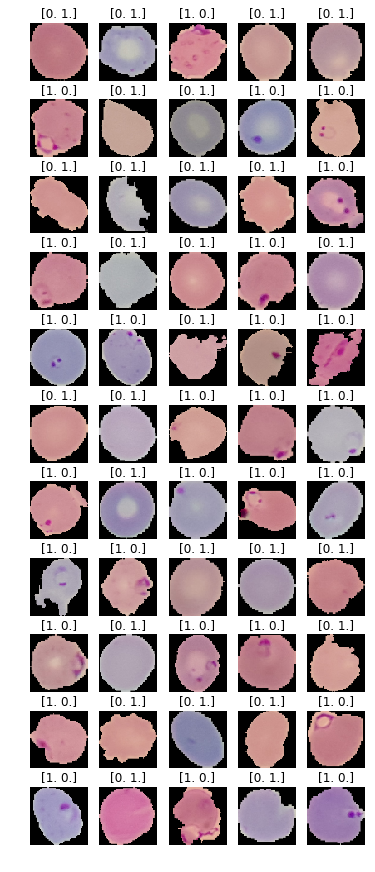

In [47]:
tile_plot(train)

<MapDataset shapes: ((70, 70, 3), (2,)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((70, 70, 1), (2,)), types: (tf.float32, tf.float32)>


<Figure size 576x576 with 0 Axes>

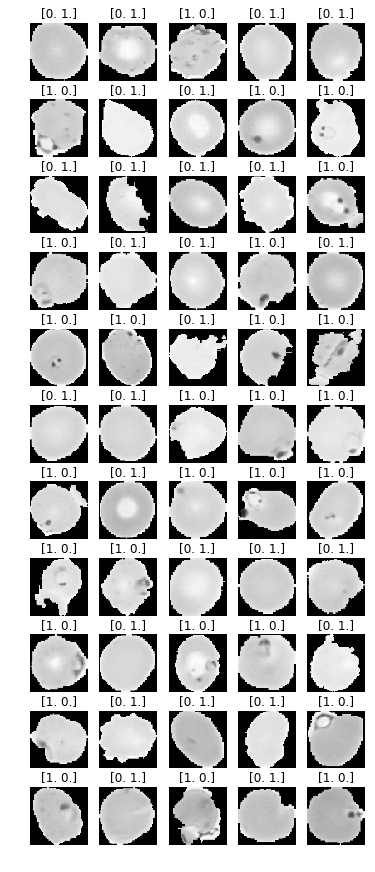

In [48]:
print(train)
train = train.map(lambda x,y  : (tf.image.rgb_to_grayscale(x), y) )
test = test.map(lambda x,y  : (tf.image.rgb_to_grayscale(x), y) )
print(train)
tile_plot(train,greyscale=True)

In [49]:
#normalize the data
print(train)
train = train.map(lambda x,y: (tf.image.per_image_standardization(
    x), y))
test = test.map(lambda x,y: (tf.image.per_image_standardization(
    x), y))
print(train)

<MapDataset shapes: ((70, 70, 1), (2,)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((70, 70, 1), (2,)), types: (tf.float32, tf.float32)>


<Figure size 576x576 with 0 Axes>

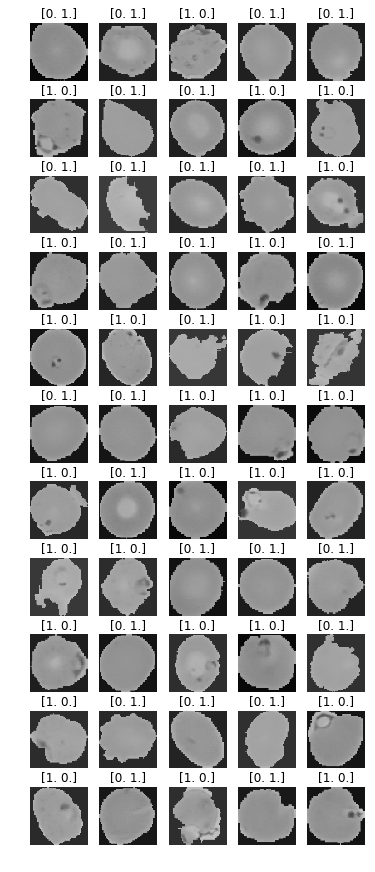

In [50]:
tile_plot(train,greyscale=True,scale=True)

A lower batch size really worsen the results you can get. With batch size 32, our network only managed to get 80% accuracy. It is definitely worth considering how to choose that hyperparameter carefully.

Otherwise, we ready our data pipeline here.

In [51]:
train = train.batch(64).shuffle(buffer_size=64).prefetch(12)
test = test.batch(64).shuffle(buffer_size=64).prefetch(12)

print(train)

<PrefetchDataset shapes: ((None, 70, 70, 1), (None, 2)), types: (tf.float32, tf.float32)>


In [52]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the 9 layers, alternating between convolutional(relu) and pooling layers,
        # ending with global average pooling and an softmax output layer

        self.conv_layer_1= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu)

        self.pool_layer_2= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')

        self.conv_layer_3= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu)

        self.pool_layer_4= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')

        self.conv_layer_5= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu)

        self.pool_layer_6= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')

        self.conv_layer_7= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu)

        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer_10 = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)

    #propagates the input through the network
    #tf.function decorator models function as a graph
    @tf.function 
    def call(self, x):
        # Define the forward step.
        x = self.conv_layer_1(x)
        x = self.pool_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.pool_layer_4(x)
        x = self.conv_layer_5(x)
        x = self.pool_layer_6(x)
        x = self.conv_layer_7(x)
        x = self.global_pooling_layer_8(x)
        x = self.output_layer_10(x)
        return x

In [53]:
def train_step(model, data, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  
  with tf.GradientTape() as tape:
    prediction = model(data)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss 

def test_step(model, test, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (data, target) in test:
    prediction = model(data)
    
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [54]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = 0.0005
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test_step(model, test, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test_step(model, train, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (data,target) in train:
        train_loss = train_step(model, data, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test_step(model, test, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4


KeyboardInterrupt: 

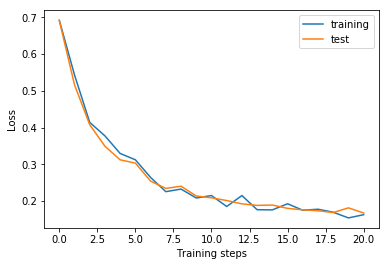

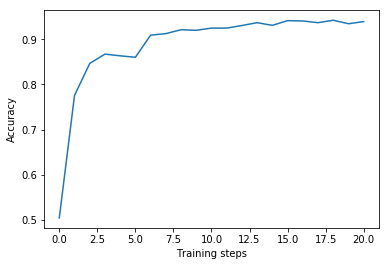

In [30]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()